<a href="https://colab.research.google.com/github/JavierPerrote/DESARROLLO-DE-UN-SENSOR-SOFTWARE-PARA-LA-ESTIMACION-DE-MATERIA-SECA-EN-UN-PROCESO-INDUSTRIAL/blob/main/Modelado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import pandas as pd
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math as math
import scipy.signal
import re
import seaborn as sns

In [ ]:
dataFile = pd.read_csv('sensor.csv')

In [ ]:
#transformo las Presiones de los ultimos dos efectos a presiones relativas
dataFile["P_vah_e5"] = dataFile["P_vah_e5"] - 1.013251
dataFile["P_vah_e6"] = dataFile["P_vah_e6"] - 1.013251

In [ ]:
# Primero generamos el filtro
dataFiltered = dataFile.copy()
for index,column in enumerate(dataFile.columns):


    if (column == 'Output'):
        b, a = scipy.signal.butter(2, 0.007)
        dataFiltered[column] = scipy.signal.filtfilt(b, a, dataFile[column], axis=0,padlen=100 )


    if re.match(r'^[pP]_va[hp]', column):
        b, a = scipy.signal.butter(2, 0.003)
        dataFiltered[column] = scipy.signal.filtfilt(b, a, dataFile[column], axis=0,padlen=100 )


    if (column.startswith('T_')):
        b, a = scipy.signal.butter(2, 0.005)
        dataFiltered[column] = scipy.signal.filtfilt(b, a, dataFile[column], axis=0,padlen=100 )


    if re.match(r'^e._T', column):
        b, a = scipy.signal.butter(2, 0.005)
        dataFiltered[column] = scipy.signal.filtfilt(b, a, dataFile[column], axis=0,padlen=100 )

    if (column.startswith('W_')):
        b, a = scipy.signal.butter(2, 0.005)
        dataFiltered[column] = scipy.signal.filtfilt(b, a, dataFile[column], axis=0,padlen=100 )


In [ ]:
dataFiltered.drop(['W_jugo_R4', 'W_jugo_R8', 'W_jugo_R9', 'W_jugo_anteevap'], axis=1, inplace=True)

In [ ]:
# separamos los atributos de la clase
X = dataFiltered.drop(columns = ["Output"])
y = dataFiltered["Output"]


In [ ]:
#rep 1
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar características del conjunto de entrenamiento
scaler_train = MinMaxScaler()
X_train_norm = scaler_train.fit_transform(X_train)

# Normalizar características del conjunto de prueba
X_test_norm = scaler_train.transform(X_test)

# Normalizar la variable respuesta del conjunto de entrenamiento
y_scaler_train = MinMaxScaler()
y_train_norm = y_scaler_train.fit_transform(y_train.values.reshape(-1, 1))

# Normalizar la variable respuesta del conjunto de prueba
y_test_norm = y_scaler_train.transform(y_test.values.reshape(-1, 1))

from sklearn.decomposition import PCA

# Realizar ACP en el conjunto de entrenamiento
pca_train = PCA(n_components=10)
X_train_pca = pca_train.fit_transform(X_train_norm)

# Proyectar el conjunto de prueba en el espacio de los componentes principales
X_test_pca = pca_train.transform(X_test_norm)


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

# Definir modelo para búsqueda de hiperparámetros

def create_model(num_layers, num_neurons, learning_rate):
    model = keras.Sequential()
    model.add(layers.Input(shape=X_train_pca.shape[1]))

    # Capas ocultas
    for i in range(num_layers):
        model.add(layers.Dense(units=num_neurons, activation='relu'))

    # Capa de salida
    model.add(layers.Dense(units=1, activation='linear'))

    # Compilación del modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mse']
    )
    return model

# Construimos el estimador Keras para poder disfrutar de las ventajas de Scikit-Learn
Keras = KerasRegressor(build_fn=create_model, verbose=0)

# Definimos los hiperparámetros y sus posibles valores
param_distribs = {
    'num_layers': [1,2,3],
    'num_neurons': [5,10,15,20],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Búsqueda aleatoria con validación cruzada
rnd_search_cv = GridSearchCV(Keras, param_grid=param_distribs,
                             scoring='neg_mean_squared_error')

rnd_search_cv.fit(X_train_pca, y_train_norm, epochs=10)
# Obtenemos el mejor modelo
best_model = rnd_search_cv.best_estimator_.model


In [ ]:

# Mostramos los hiperparámetros del mejor modelo
print("Hiperparámetros del mejor modelo:")
print(rnd_search_cv.best_params_)


Hiperparámetros del mejor modelo:
{'learning_rate': 0.01, 'num_neurons': 20}


In [ ]:

import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

# Entrenar el modelo con todos los datos de entrenamiento
best_model.fit(X_train_pca, y_train_norm,epochs=10)

# Realizar predicciones con el modelo
y_pred_train = best_model.predict(X_train_pca)
y_pred_test = best_model.predict(X_test_pca)

# Calcular el error cuadrático medio para los datos de entrenamiento y prueba
mse_train = mean_squared_error(y_train_norm, y_pred_train)
mse_test = mean_squared_error(y_test_norm, y_pred_test)

print("MSE en datos de entrenamiento: ", mse_train)
print("MSE en datos de prueba: ", mse_test)


Epoch 1/10
864/864 [==============================] - 6s 7ms/step - loss: 1.6543e-04 - mse: 1.6543e-04
Epoch 2/10
864/864 [==============================] - 12s 14ms/step - loss: 1.8588e-04 - mse: 1.8588e-04
Epoch 3/10
864/864 [==============================] - 3s 4ms/step - loss: 1.8352e-04 - mse: 1.8352e-04
Epoch 4/10
864/864 [==============================] - 4s 4ms/step - loss: 1.3415e-04 - mse: 1.3415e-04
Epoch 5/10
864/864 [==============================] - 6s 7ms/step - loss: 1.4423e-04 - mse: 1.4423e-04
Epoch 6/10
864/864 [==============================] - 5s 6ms/step - loss: 1.8136e-04 - mse: 1.8136e-04
Epoch 7/10
864/864 [==============================] - 4s 5ms/step - loss: 1.1870e-04 - mse: 1.1870e-04
Epoch 8/10
864/864 [==============================] - 5s 6ms/step - loss: 8.4274e-05 - mse: 8.4274e-05
Epoch 9/10
864/864 [==============================] - 6s 7ms/step - loss: 1.4143e-04 - mse: 1.4143e-04
Epoch 10/10
216/216 [==============================] - 0s 1ms/step
MSE 

In [ ]:
y_pred_train_desnormalizado = y_scaler_train.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_desnormalizado = y_scaler_train.inverse_transform(y_pred_test.reshape(-1,1))

mse_train_desnormalizado = mean_squared_error(y_train, y_pred_train_desnormalizado)
mse_test_desnormalizado = mean_squared_error(y_test, y_pred_test_desnormalizado)

print("MSE en datos de entrenamiento desnormalizado: ", mse_train_desnormalizado)
print("MSE en datos de prueba desnormalizado: ", mse_test_desnormalizado)


MSE en datos de entrenamiento desnormalizado:  0.008673738465837591
MSE en datos de prueba desnormalizado:  1.636610503550101


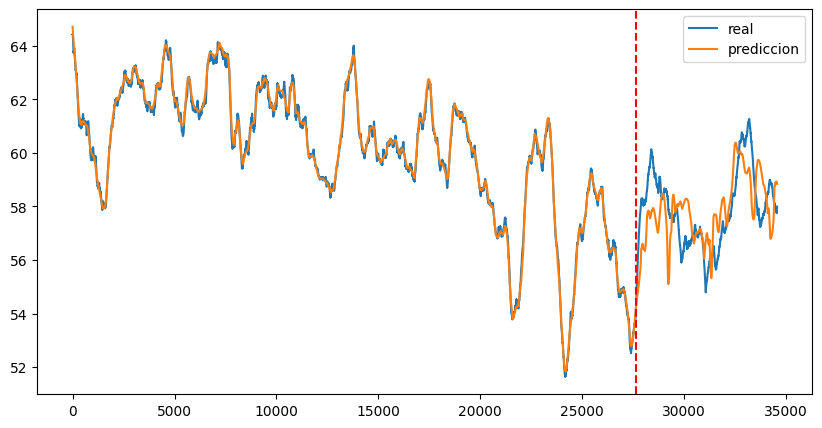

In [ ]:
x=np.arange(0,len(dataFile['Output']))
#Output
plt.rcParams['figure.figsize'] = [10, 5]
actual = np.append(y_train, y_test)
predictions = np.append(y_pred_train_desnormalizado, y_pred_test_desnormalizado)
plt.figure()
plt.plot(x, dataFile['Output'] , label='real')
plt.plot(x,predictions, label='prediccion')
plt.axvline(x=len(y_train), color='red', linestyle='--')
plt.legend()

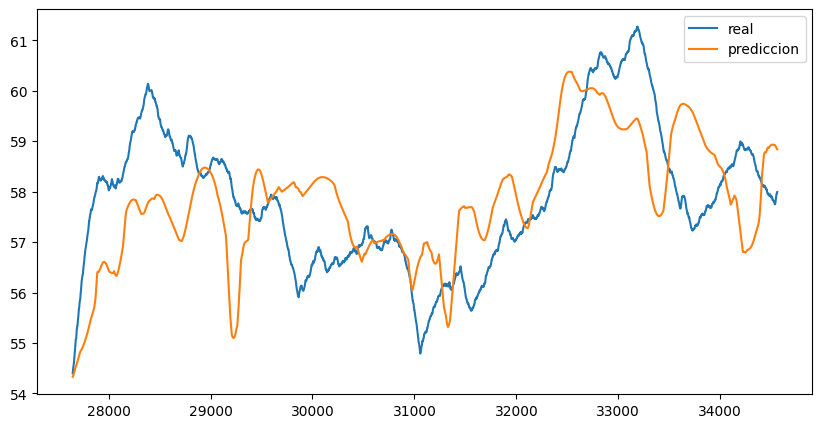

In [ ]:
x=np.arange(len(y_train),len(dataFile['Output']))
#Output
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(x, dataFile['Output'][len(y_train):] , label='real')
plt.plot(x,y_pred_test_desnormalizado, label='prediccion')

plt.legend()

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

# Definir modelo para búsqueda de hiperparámetros

def create_model(num_layers,num_neurons, learning_rate):
    model = keras.Sequential()
    model.add(layers.Input(shape=X_train_pca.shape[1]))

    # Capas ocultas
    for i in range(2):
        model.add(layers.Dense(units=num_neurons, activation='relu'))

    # Capa de salida
    model.add(layers.Dense(units=1, activation='linear'))

    # Compilación del modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mse']
    )
    return model

# Construimos el estimador Keras para poder disfrutar de las ventajas de Scikit-Learn
Keras = KerasRegressor(build_fn=create_model, verbose=0)

# Definimos los hiperparámetros y sus posibles valores
param_distribs = {
    'num_layers': [1,2],
    'num_neurons': [5,10,15],
    'learning_rate': [0.001, 0.01,0.1]
}

# Búsqueda aleatoria con validación cruzada
rnd_search_cv = GridSearchCV(Keras, param_grid=param_distribs,
                             scoring='neg_mean_squared_error')
#rnd_search_cv.fit(X_train_pca, y_train_norm)
rnd_search_cv.fit(X_train_pca, y_train_norm, epochs=10)
# Obtenemos el mejor modelo
best_model = rnd_search_cv.best_estimator_.model


In [ ]:

# Mostramos los hiperparámetros del mejor modelo
print("Hiperparámetros del mejor modelo:")
print(rnd_search_cv.best_params_)

Hiperparámetros del mejor modelo:
{'learning_rate': 0.001, 'num_neurons': 5}


In [ ]:

import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

# Entrenar el modelo con todos los datos de entrenamiento
best_model.fit(X_train_pca, y_train_norm,epochs=10)

# Realizar predicciones con el modelo
y_pred_train = best_model.predict(X_train_pca)
y_pred_test = best_model.predict(X_test_pca)

# Calcular el error cuadrático medio para los datos de entrenamiento y prueba
mse_train = mean_squared_error(y_train_norm, y_pred_train)
mse_test = mean_squared_error(y_test_norm, y_pred_test)

print("MSE en datos de entrenamiento: ", mse_train)
print("MSE en datos de prueba: ", mse_test)


Epoch 1/10
864/864 [==============================] - 5s 5ms/step - loss: 0.0012 - mse: 0.0012
Epoch 2/10
864/864 [==============================] - 4s 5ms/step - loss: 0.0011 - mse: 0.0011
Epoch 3/10
864/864 [==============================] - 5s 5ms/step - loss: 0.0011 - mse: 0.0011
Epoch 4/10
864/864 [==============================] - 4s 5ms/step - loss: 0.0011 - mse: 0.0011
Epoch 5/10
864/864 [==============================] - 3s 3ms/step - loss: 0.0010 - mse: 0.0010
Epoch 6/10
864/864 [==============================] - 4s 4ms/step - loss: 0.0010 - mse: 0.0010
Epoch 7/10
864/864 [==============================] - 7s 8ms/step - loss: 0.0010 - mse: 0.0010
Epoch 8/10
864/864 [==============================] - 3s 4ms/step - loss: 0.0010 - mse: 0.0010
Epoch 9/10
864/864 [==============================] - 7s 8ms/step - loss: 0.0010 - mse: 0.0010
Epoch 10/10
216/216 [==============================] - 1s 7ms/step
MSE en datos de entrenamiento:  0.0010378149619140816
MSE en datos de prueba: 

In [ ]:
y_pred_train_desnormalizado = y_scaler_train.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_desnormalizado = y_scaler_train.inverse_transform(y_pred_test.reshape(-1,1))

mse_train_desnormalizado = mean_squared_error(y_train, y_pred_train_desnormalizado)
mse_test_desnormalizado = mean_squared_error(y_test, y_pred_test_desnormalizado)

print("MSE en datos de entrenamiento desnormalizado: ", mse_train_desnormalizado)
print("MSE en datos de prueba desnormalizado: ", mse_test_desnormalizado)


MSE en datos de entrenamiento desnormalizado:  0.16720824155158448
MSE en datos de prueba desnormalizado:  1.3773365540682747


In [ ]:
x=np.arange(0,len(dataFile['Output']))
#Output
plt.rcParams['figure.figsize'] = [10, 5]
actual = np.append(y_train, y_test)
predictions = np.append(y_pred_train_desnormalizado, y_pred_test_desnormalizado)
plt.figure()
plt.plot(x, dataFile['Output'] , label='real')
plt.plot(x,predictions, label='prediccion')
plt.axvline(x=len(y_train), color='red', linestyle='--')
plt.legend()

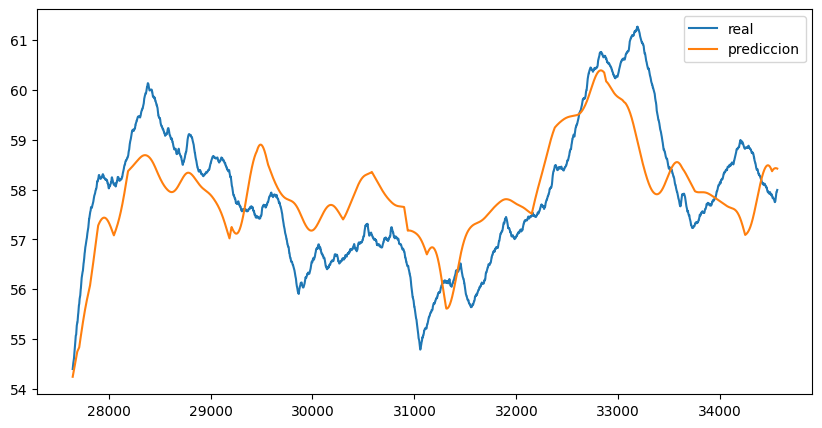

In [ ]:
x=np.arange(len(y_train),len(dataFile['Output']))
#Output
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(x, dataFile['Output'][len(y_train):] , label='real')
plt.plot(x,y_pred_test_desnormalizado, label='prediccion')

plt.legend()

RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint


# Define el espacio de búsqueda de los hiperparámetros
param_distributions = {
    'n_estimators': [5,10,15,20],
    'max_depth': [3,5,7,9],
    'max_features': ['sqrt', 'log2']
}

# Crea el modelo a optimizar
model = RandomForestRegressor()


# Realiza la búsqueda de hiperparámetros con k-fold cross-validation
search = GridSearchCV(model, param_grid=param_distributions, scoring='neg_mean_squared_error')

search.fit(X_train_pca, y_train_norm)

# Obtiene el modelo con los mejores hiperparámetros
best_model = search.best_estimator_


In [ ]:
# Mostramos los hiperparámetros del mejor modelo
print("Hiperparámetros del mejor modelo:")
print(search.best_params_)

Hiperparámetros del mejor modelo:
{'max_depth': 7, 'max_features': 'log2', 'n_estimators': 10}


In [ ]:

import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

# Entrenar el modelo con todos los datos de entrenamiento
best_model.fit(X_train_pca, y_train_norm)

# Realizar predicciones con el modelo
y_pred_train = best_model.predict(X_train_pca)
y_pred_test = best_model.predict(X_test_pca)

# Calcular el error cuadrático medio para los datos de entrenamiento y prueba
mse_train = mean_squared_error(y_train_norm, y_pred_train)
mse_test = mean_squared_error(y_test_norm, y_pred_test)

print("MSE en datos de entrenamiento: ", mse_train)
print("MSE en datos de prueba: ", mse_test)


<ipython-input-28-eb9fa55cd6d4>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model.fit(X_train_pca, y_train_norm)


MSE en datos de entrenamiento:  0.0011251038329476997
MSE en datos de prueba:  0.00969687856373806


In [ ]:
y_pred_train_desnormalizado = y_scaler_train.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_desnormalizado = y_scaler_train.inverse_transform(y_pred_test.reshape(-1,1))

mse_train_desnormalizado = mean_squared_error(y_train, y_pred_train_desnormalizado)
mse_test_desnormalizado = mean_squared_error(y_test, y_pred_test_desnormalizado)

print("MSE en datos de entrenamiento desnormalizado: ", mse_train_desnormalizado)
print("MSE en datos de prueba desnormalizado: ", mse_test_desnormalizado)


MSE en datos de entrenamiento desnormalizado:  0.18127183276838701
MSE en datos de prueba desnormalizado:  1.5623188704068616


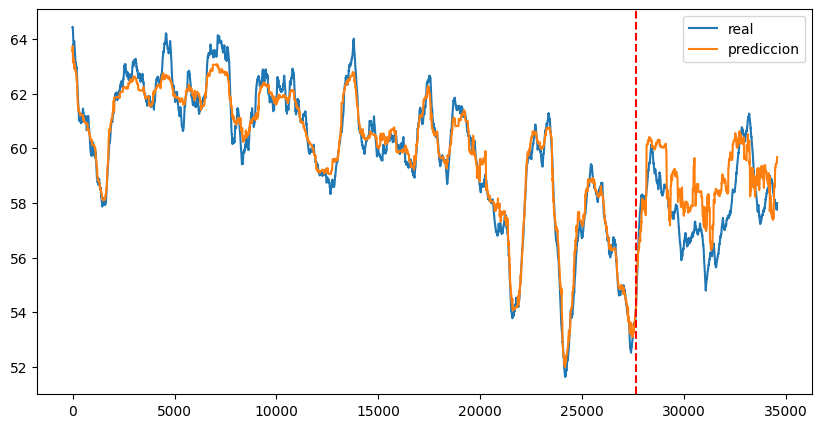

In [ ]:
x=np.arange(0,len(dataFile['Output']))
#Output
plt.rcParams['figure.figsize'] = [10, 5]
actual = np.append(y_train, y_test)
predictions = np.append(y_pred_train_desnormalizado, y_pred_test_desnormalizado)
plt.figure()
plt.plot(x, dataFile['Output'] , label='real')
plt.plot(x,predictions, label='prediccion')
plt.axvline(x=len(y_train), color='red', linestyle='--')
plt.legend()

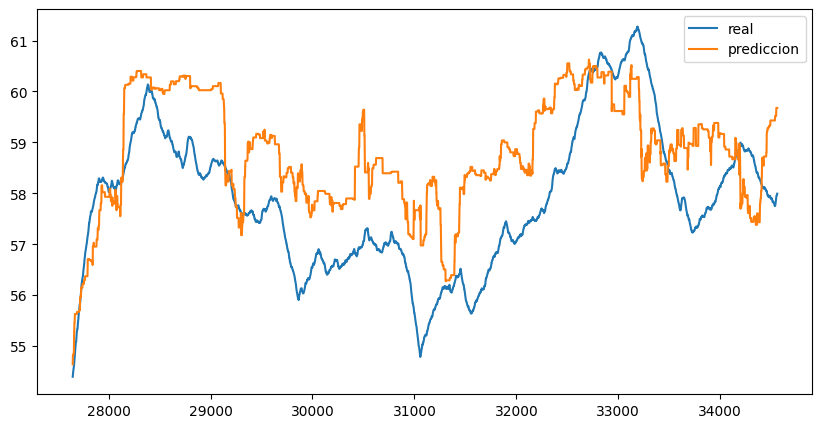

In [ ]:
x=np.arange(len(y_train),len(dataFile['Output']))
#Output
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(x, dataFile['Output'][len(y_train):] , label='real')
plt.plot(x,y_pred_test_desnormalizado, label='prediccion')

plt.legend()

In [ ]:
import random
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint


# Define el espacio de búsqueda de los hiperparámetros
param_distributions = {
    'n_estimators': [5,10,15],
    'max_depth': [3,5],
    'max_features': ['sqrt', 'log2']
}

# Crea el modelo a optimizar
model = RandomForestRegressor()

# Realiza la búsqueda de hiperparámetros con k-fold cross-validation
search = GridSearchCV(model, param_grid=param_distributions, scoring='neg_mean_squared_error')
search.fit(X_train_pca, y_train_norm)

# Obtiene el modelo con los mejores hiperparámetros
best_model = search.best_estimator_




In [ ]:
# Mostramos los hiperparámetros del mejor modelo
print("Hiperparámetros del mejor modelo:")
print(search.best_params_)

Hiperparámetros del mejor modelo:
{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 5}


In [ ]:

import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

# Entrenar el modelo con todos los datos de entrenamiento
best_model.fit(X_train_pca, y_train_norm)

# Realizar predicciones con el modelo
y_pred_train = best_model.predict(X_train_pca)
y_pred_test = best_model.predict(X_test_pca)

# Calcular el error cuadrático medio para los datos de entrenamiento y prueba
mse_train = mean_squared_error(y_train_norm, y_pred_train)
mse_test = mean_squared_error(y_test_norm, y_pred_test)

print("MSE en datos de entrenamiento: ", mse_train)
print("MSE en datos de prueba: ", mse_test)


MSE en datos de entrenamiento:  0.002338875702308908
MSE en datos de prueba:  0.011651930014013266


In [ ]:
y_pred_train_desnormalizado = y_scaler_train.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_desnormalizado = y_scaler_train.inverse_transform(y_pred_test.reshape(-1,1))

mse_train_desnormalizado = mean_squared_error(y_train, y_pred_train_desnormalizado)
mse_test_desnormalizado = mean_squared_error(y_test, y_pred_test_desnormalizado)

print("MSE en datos de entrenamiento desnormalizado: ", mse_train_desnormalizado)
print("MSE en datos de prueba desnormalizado: ", mse_test_desnormalizado)


MSE en datos de entrenamiento desnormalizado:  0.3768294736532926
MSE en datos de prueba desnormalizado:  1.8773082510930734


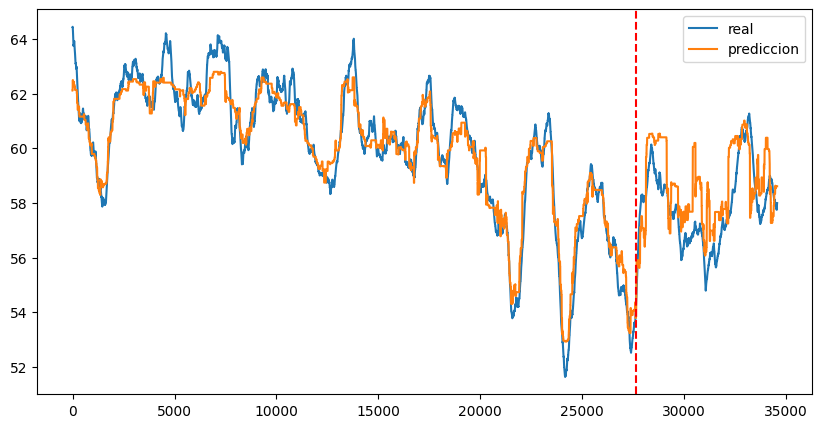

In [ ]:
x=np.arange(0,len(dataFile['Output']))
#Output
plt.rcParams['figure.figsize'] = [10, 5]
actual = np.append(y_train, y_test)
predictions = np.append(y_pred_train_desnormalizado, y_pred_test_desnormalizado)
plt.figure()
plt.plot(x, dataFile['Output'] , label='real')
plt.plot(x,predictions, label='prediccion')
plt.axvline(x=len(y_train), color='red', linestyle='--')
plt.legend()

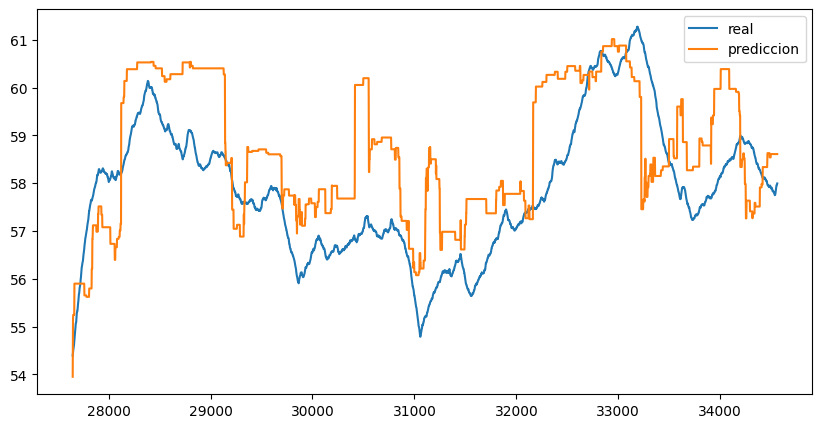

In [ ]:
x=np.arange(len(y_train),len(dataFile['Output']))
#Output
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(x, dataFile['Output'][len(y_train):] , label='real')
plt.plot(x,y_pred_test_desnormalizado, label='prediccion')

plt.legend()

SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# Define el espacio de búsqueda de los hiperparámetros
param_distributions = {
    'C': [0.1,1,5,10],
    'epsilon': [0.1,1,5,10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Crea el modelo a optimizar
model = SVR()

# Realiza la búsqueda de hiperparámetros con k-fold cross-validation
search =  GridSearchCV(model,param_grid=param_distributions,
                             scoring='neg_mean_squared_error')
search.fit(X_train_pca, y_train_norm)

# Obtiene el modelo con los mejores hiperparámetros
best_model = search.best_estimator_


In [ ]:
# Mostramos los hiperparámetros del mejor modelo
print("Hiperparámetros del mejor modelo:")
print(search.best_params_)

Hiperparámetros del mejor modelo:
{'C': 0.01, 'epsilon': 0.1}


In [ ]:

import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

# Entrenar el modelo con todos los datos de entrenamiento
best_model.fit(X_train_pca, y_train_norm)

# Realizar predicciones con el modelo
y_pred_train = best_model.predict(X_train_pca)
y_pred_test = best_model.predict(X_test_pca)

# Calcular el error cuadrático medio para los datos de entrenamiento y prueba
mse_train = mean_squared_error(y_train_norm, y_pred_train)
mse_test = mean_squared_error(y_test_norm, y_pred_test)

print("MSE en datos de entrenamiento: ", mse_train)
print("MSE en datos de prueba: ", mse_test)


MSE en datos de entrenamiento:  0.0038229021504769473
MSE en datos de prueba:  0.004864470315337922


In [ ]:
y_pred_train_desnormalizado = y_scaler_train.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_desnormalizado = y_scaler_train.inverse_transform(y_pred_test.reshape(-1,1))

mse_train_desnormalizado = mean_squared_error(y_train, y_pred_train_desnormalizado)
mse_test_desnormalizado = mean_squared_error(y_test, y_pred_test_desnormalizado)

print("MSE en datos de entrenamiento desnormalizado: ", mse_train_desnormalizado)
print("MSE en datos de prueba desnormalizado: ", mse_test_desnormalizado)


MSE en datos de entrenamiento desnormalizado:  0.6159293560449342
MSE en datos de prueba desnormalizado:  0.783742285543976


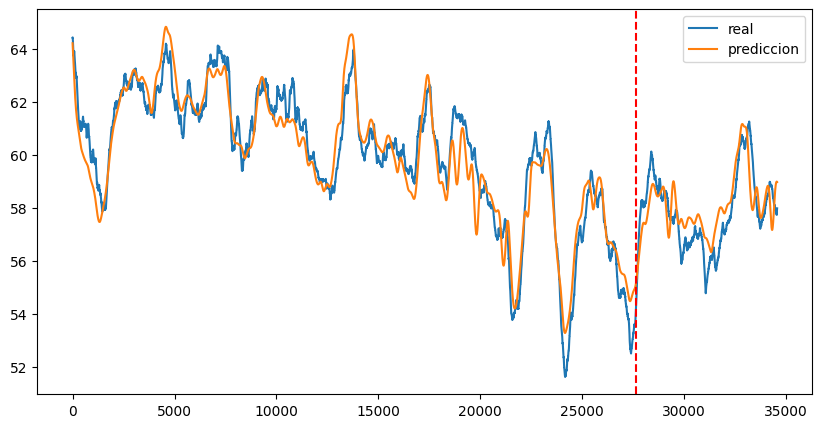

In [ ]:
x=np.arange(0,len(dataFile['Output']))
#Output
plt.rcParams['figure.figsize'] = [10, 5]
actual = np.append(y_train, y_test)
predictions = np.append(y_pred_train_desnormalizado, y_pred_test_desnormalizado)
plt.figure()
plt.plot(x, dataFile['Output'] , label='real')
plt.plot(x,predictions, label='prediccion')
plt.axvline(x=len(y_train), color='red', linestyle='--')
plt.legend()

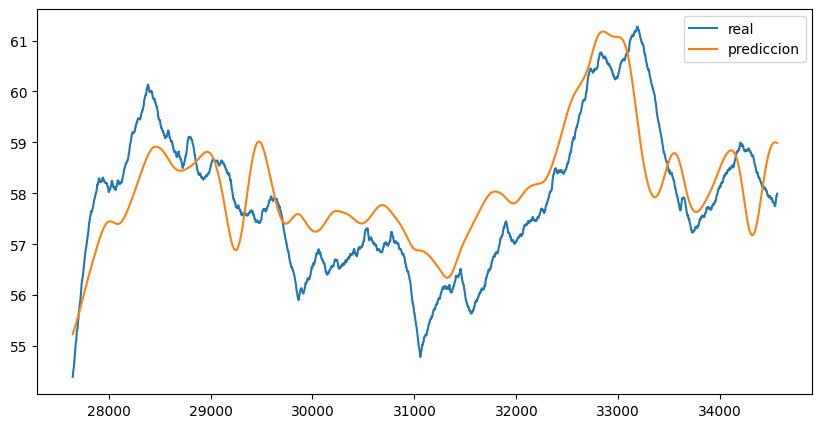

In [ ]:
x=np.arange(len(y_train),len(dataFile['Output']))
#Output
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(x, dataFile['Output'][len(y_train):] , label='real')
plt.plot(x,y_pred_test_desnormalizado, label='prediccion')

plt.legend()

PLS

In [ ]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

model = PLSRegression()

param_distributions = {
  'n_components': np.arange(1, X_train_norm.shape[1]+1)
}
# Realiza la búsqueda de hiperparámetros con k-fold cross-validation
search =  GridSearchCV(model,param_grid=param_distributions,
                             scoring='neg_mean_squared_error')
search.fit(X_train_norm, y_train_norm)

# Obtiene el modelo con los mejores hiperparámetros
best_model = search.best_estimator_

In [ ]:
# Mostramos los hiperparámetros del mejor modelo
print("Hiperparámetros del mejor modelo:")
print(search.best_params_)

Hiperparámetros del mejor modelo:
{'n_components': 22}


In [ ]:

import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

# Entrenar el modelo con todos los datos de entrenamiento
best_model.fit(X_train_norm, y_train_norm)

# Realizar predicciones con el modelo
y_pred_train = best_model.predict(X_train_norm)
y_pred_test = best_model.predict(X_test_norm)

# Calcular el error cuadrático medio para los datos de entrenamiento y prueba
mse_train = mean_squared_error(y_train_norm, y_pred_train)
mse_test = mean_squared_error(y_test_norm, y_pred_test)

print("MSE en datos de entrenamiento: ", mse_train)
print("MSE en datos de prueba: ", mse_test)


MSE en datos de entrenamiento:  0.0006935268072747953
MSE en datos de prueba:  0.004455610962136712


In [ ]:

y_pred_train_desnormalizado = y_scaler_train.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_desnormalizado = y_scaler_train.inverse_transform(y_pred_test.reshape(-1,1))

mse_train_desnormalizado = mean_squared_error(y_train, y_pred_train_desnormalizado)
mse_test_desnormalizado = mean_squared_error(y_test, y_pred_test_desnormalizado)

print("MSE en datos de entrenamiento desnormalizado: ", mse_train_desnormalizado)
print("MSE en datos de prueba desnormalizado: ", mse_test_desnormalizado)


MSE en datos de entrenamiento desnormalizado:  0.11173802074724055
MSE en datos de prueba desnormalizado:  0.7178686460372072


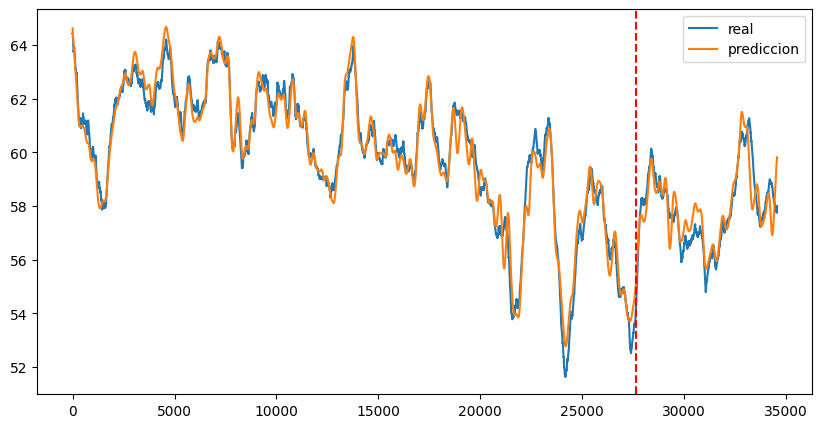

In [ ]:
x=np.arange(0,len(dataFile['Output']))
#Output
plt.rcParams['figure.figsize'] = [10, 5]
actual = np.append(y_train, y_test)
predictions = np.append(y_pred_train_desnormalizado, y_pred_test_desnormalizado)
plt.figure()
plt.plot(x, dataFile['Output'] , label='real')
plt.plot(x,predictions, label='prediccion')
plt.axvline(x=len(y_train), color='red', linestyle='--')
plt.legend()

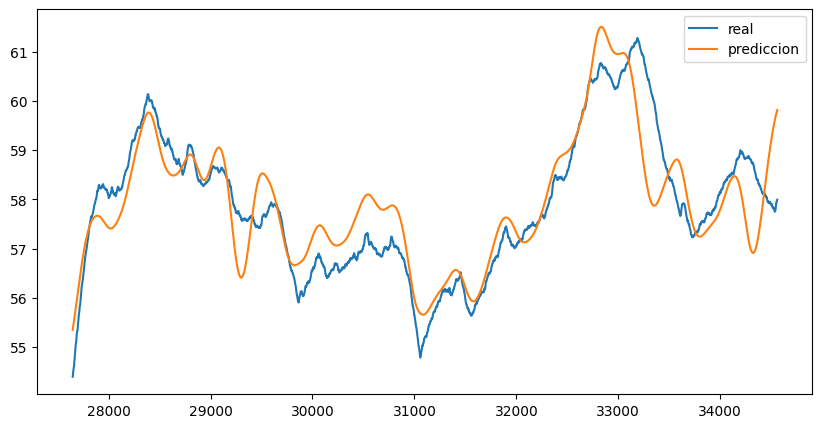

In [ ]:
x=np.arange(len(y_train),len(dataFile['Output']))
#Output
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(x, dataFile['Output'][len(y_train):] , label='real')
plt.plot(x,y_pred_test_desnormalizado, label='prediccion')

plt.legend()

In [ ]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

model = PLSRegression()

param_distributions = {
  'n_components': np.arange(1, X_train_pca.shape[1]+1)
}
# Realiza la búsqueda de hiperparámetros con k-fold cross-validation
search =  GridSearchCV(model,param_grid=param_distributions,
                             scoring='neg_mean_squared_error')
search.fit(X_train_norm, y_train_norm)

# Obtiene el modelo con los mejores hiperparámetros
best_model = search.best_estimator_

In [ ]:
# Mostramos los hiperparámetros del mejor modelo
print("Hiperparámetros del mejor modelo:")
print(search.best_params_)

Hiperparámetros del mejor modelo:
{'n_components': 10}


In [ ]:

import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

# Entrenar el modelo con todos los datos de entrenamiento
best_model.fit(X_train_norm, y_train_norm)

# Realizar predicciones con el modelo
y_pred_train = best_model.predict(X_train_norm)
y_pred_test = best_model.predict(X_test_norm)

# Calcular el error cuadrático medio para los datos de entrenamiento y prueba
mse_train = mean_squared_error(y_train_norm, y_pred_train)
mse_test = mean_squared_error(y_test_norm, y_pred_test)

print("MSE en datos de entrenamiento: ", mse_train)
print("MSE en datos de prueba: ", mse_test)


MSE en datos de entrenamiento:  0.001428606130071047
MSE en datos de prueba:  0.0027818547841592517


In [ ]:

y_pred_train_desnormalizado = y_scaler_train.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_desnormalizado = y_scaler_train.inverse_transform(y_pred_test.reshape(-1,1))

mse_train_desnormalizado = mean_squared_error(y_train, y_pred_train_desnormalizado)
mse_test_desnormalizado = mean_squared_error(y_test, y_pred_test_desnormalizado)

print("MSE en datos de entrenamiento desnormalizado: ", mse_train_desnormalizado)
print("MSE en datos de prueba desnormalizado: ", mse_test_desnormalizado)


MSE en datos de entrenamiento desnormalizado:  0.23017080194603617
MSE en datos de prueba desnormalizado:  0.4482003353405106


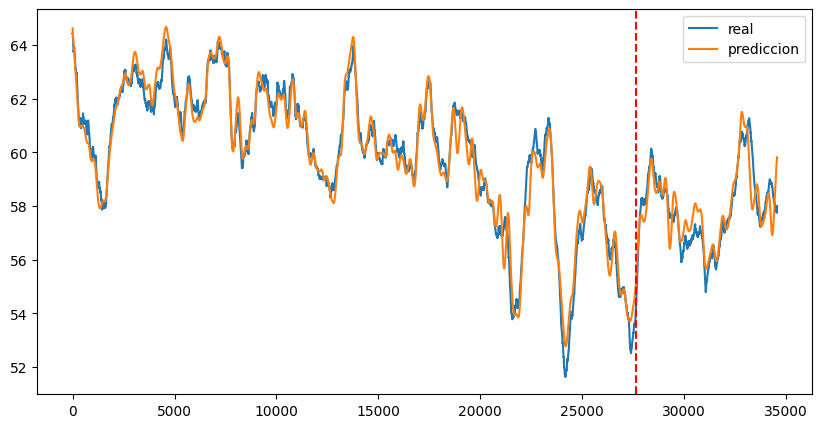

In [ ]:
x=np.arange(0,len(dataFile['Output']))
#Output
plt.rcParams['figure.figsize'] = [10, 5]
actual = np.append(y_train, y_test)
predictions = np.append(y_pred_train_desnormalizado, y_pred_test_desnormalizado)
plt.figure()
plt.plot(x, dataFile['Output'] , label='real')
plt.plot(x,predictions, label='prediccion')
plt.axvline(x=len(y_train), color='red', linestyle='--')
plt.legend()

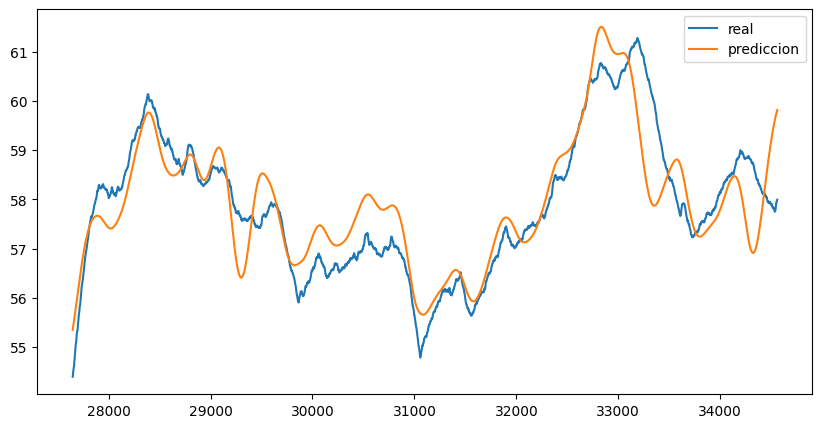

In [ ]:
x=np.arange(len(y_train),len(dataFile['Output']))
#Output
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(x, dataFile['Output'][len(y_train):] , label='real')
plt.plot(x,y_pred_test_desnormalizado, label='prediccion')

plt.legend()